Необходимо подготовить модель для предсказания коэффициента восстановления золота из золотосодержащей руды. 

# Подготовка данных

## Импорт библиотек. Обзор данных.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date')
test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date')
train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date')

## Расчет recovery. Сравнение с данным в таблице. Расчет MAE.

In [3]:
def recovery(c, f, t):
    return c * (f - t) * 100 / (f * (c - t))

In [4]:
c_rougher = train['rougher.output.concentrate_au']
f_rougher = train['rougher.input.feed_au']
t_rougher = train['rougher.output.tail_au']
recovery_rougher = recovery(c_rougher, f_rougher, t_rougher)
mae(recovery_rougher, train['rougher.output.recovery'])

1.1131451184435918e-14

MAE очень низкое. Значит ошибка очень низкая. Значит целевой признак отображен корректно.

## Данные, которых нет в тестовой выборке

In [5]:
full.drop(test.columns, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

В тестовой выборке отсутствуют целевые признаки, а так же ряд других полезных для обучения данных..


Оставим в обучающем датасете тот же набор признаков, что и в тестовом датасете

In [6]:
train_2 = train[test.columns]
test_2 = test  # для удобства, что бы не путаться с индексами

## Предобработка данных

Выделим все выборки по новой. Заменим пустоты методом ffill

In [8]:
# Заполнение пропусков
test_2 = test_2.fillna(method='ffill')
train_2 = train_2.fillna(method='ffill')
full_2 = full.fillna(method='ffill')

# Анализ данных

## Значения концентрации металлов на разных этапах очистки

Text(0.5, 1.0, 'Изменение концентрации золота')

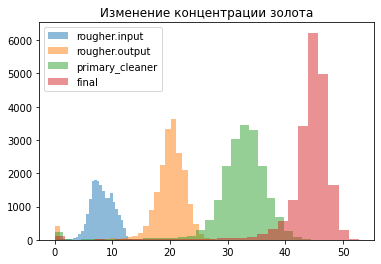

In [9]:
plt.hist(full_2['rougher.input.feed_au'], bins=30, alpha=.5, label='rougher.input')
plt.hist(full_2['rougher.output.concentrate_au'], bins=30, alpha=.5, label='rougher.output')
plt.hist(full_2['primary_cleaner.output.concentrate_au'], bins=30, alpha=.5, label='primary_cleaner')
plt.hist(full_2['final.output.concentrate_au'], bins=30, alpha=.5, label='final')
plt.legend()
plt.title('Изменение концентрации золота')

Text(0.5, 1.0, 'Изменение концентрации серебра')

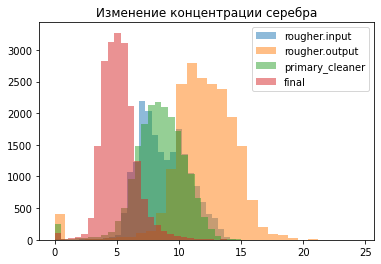

In [10]:
plt.hist(full_2['rougher.input.feed_ag'], bins=30, alpha=.5, label='rougher.input')
plt.hist(full_2['rougher.output.concentrate_ag'], bins=30, alpha=.5, label='rougher.output')
plt.hist(full_2['primary_cleaner.output.concentrate_ag'], bins=30, alpha=.5, label='primary_cleaner')
plt.hist(full_2['final.output.concentrate_ag'], bins=30, alpha=.5, label='final')
plt.legend()
plt.title('Изменение концентрации серебра')

Text(0.5, 1.0, 'Изменение концентрации свинца')

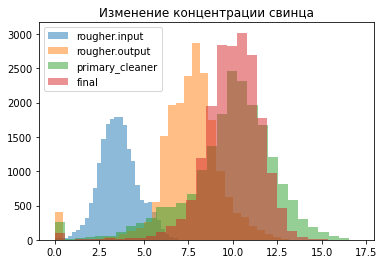

In [11]:
plt.hist(full_2['rougher.input.feed_pb'], bins=30, alpha=.5, label='rougher.input')
plt.hist(full_2['rougher.output.concentrate_pb'], bins=30, alpha=.5, label='rougher.output')
plt.hist(full_2['primary_cleaner.output.concentrate_pb'], bins=30, alpha=.5, label='primary_cleaner')
plt.hist(full_2['final.output.concentrate_pb'], bins=30, alpha=.5, label='final')
plt.legend()
plt.title('Изменение концентрации свинца')

С каждым этапом растет концентрация золота и незначительно свинца. Концентрация серебра снижается.

## Распределения размера гранул

### rougher

(array([2.100e+01, 4.720e+02, 7.542e+03, 3.731e+03, 1.842e+03, 2.770e+02,
        8.900e+01, 4.500e+01, 2.400e+01, 9.000e+00, 1.600e+01, 7.000e+00,
        1.600e+01, 5.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 4.000e+00,
        5.000e+00, 4.000e+00, 1.700e+01, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  9.65957631,  25.50317265,  41.34676899,  57.19036533,
         73.03396167,  88.87755801, 104.72115435, 120.56475069,
        136.40834703, 152.25194337, 168.09553971, 183.93913605,
        199.78273239, 215.62632873, 231.46992506, 247.3135214 ,
        263.15711774, 279.00071408, 294.84431042, 310.68790676,
        326.5315031 , 342.37509944, 358.21869578, 374.06229212,
        389.90588846, 405.7494848 , 421.59308114, 437.43667748,
        453.28027382, 469.12387015, 484.96746649]),
 <BarContainer object of 30 artists>)

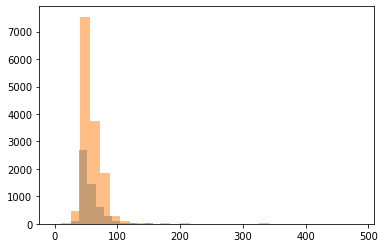

In [12]:
plt.hist(test_2['rougher.input.feed_size'], bins=30, alpha=.5)
plt.hist(train_2['rougher.input.feed_size'], bins=30, alpha=.5)

In [13]:
test_2['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

In [93]:
train_2['rougher.input.feed_size'].describe()

count    13789.000000
mean        60.253254
std         23.087127
min          9.659576
25%         48.988817
50%         55.333956
75%         65.960137
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [15]:
rougher_desp = st.ttest_ind(test_2['rougher.input.feed_size'], train_2['rougher.input.feed_size'])
rougher_desp

Ttest_indResult(statistic=-12.088216423310282, pvalue=1.6081245670851188e-33)

### final

(array([8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.300e+01, 1.200e+01, 6.200e+01, 2.330e+02, 3.600e+02, 1.272e+03,
        2.255e+03, 3.554e+03, 2.630e+03, 1.742e+03, 1.070e+03, 6.550e+02,
        2.110e+02, 4.700e+01, 2.100e+01, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([ 1.08000004,  1.39300005,  1.70600006,  2.01900007,  2.33200007,
         2.64500008,  2.95800009,  3.2710001 ,  3.5840001 ,  3.89700011,
         4.21000012,  4.52300013,  4.83600013,  5.14900014,  5.46200015,
         5.77500015,  6.08800016,  6.40100017,  6.71400018,  7.02700018,
         7.34000019,  7.6530002 ,  7.96600021,  8.27900021,  8.59200022,
         8.90500023,  9.21800024,  9.53100024,  9.84400025, 10.15700026,
        10.47000027]),
 <BarContainer object of 30 artists>)

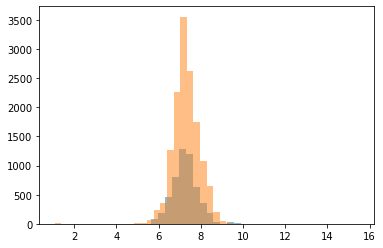

In [16]:
plt.hist(test_2['primary_cleaner.input.feed_size'], bins=30, alpha=.5)
plt.hist(train_2['primary_cleaner.input.feed_size'], bins=30, alpha=.5)

In [17]:
test_2['primary_cleaner.input.feed_size'].describe()

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

In [18]:
train_2['primary_cleaner.input.feed_size'].describe()

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

In [19]:
primary_desp = st.ttest_ind(test_2['primary_cleaner.input.feed_size'], train_2['primary_cleaner.input.feed_size'])
primary_desp

Ttest_indResult(statistic=-5.665533565560782, pvalue=1.4864182925957636e-08)

Визуально по графиук, а так же по данным распределения, значения выборок выглядят похожими.

## Суммарная концентрация сырья на разных стадиях.

In [20]:
THRESHOLD = 1
input_conz = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
prim_conz = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
fin_conz = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

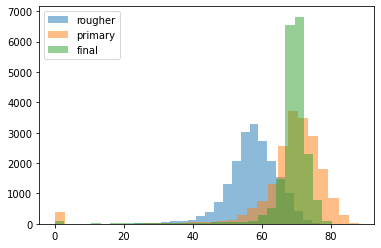

In [21]:
plt.hist(full_2[input_conz].sum(1), label='rougher', alpha=.5, bins=30)
plt.hist(full_2[prim_conz].sum(1), label='primary', alpha=.5, bins=30)
plt.hist(full_2[fin_conz].sum(1), label='final', alpha=.5, bins=30)
plt.legend()

Удалим из выборок строки, в которых суммарная концентрация металлов блзка к 0.

In [22]:
train_2 = full_2.loc[train_2.index]
train_2 = train_2[train_2[input_conz].sum(1) > THRESHOLD]
train_2 = train_2[train_2[prim_conz].sum(1) > THRESHOLD]
train_2 = train_2[train_2[fin_conz].sum(1) > THRESHOLD]
train_2 = train_2[test.columns]

In [23]:
test_2 = full_2.loc[test_2.index]
test_2 = test_2[test_2[input_conz].sum(1) > THRESHOLD]
test_2 = test_2[test_2[prim_conz].sum(1) > THRESHOLD]
test_2 = test_2[test_2[fin_conz].sum(1) > THRESHOLD]
test_2 = test_2[test.columns]

# Обучение моделей

## Функция для расчета метрики sMAPE

In [66]:
def sMAPE(y, y_hat):
    numerator = abs(y - y_hat)
    denominator = (abs(y) + abs(y_hat)) / 2
    private = numerator * 100 / denominator
    return private.sum() / len(private)


def sMAPE_total(y, y_hat):
    y_hat = pd.DataFrame(y_hat, index=y.index, columns=y.columns)
    y_rought = y['rougher.output.recovery']
    y_hat_rought = y_hat['rougher.output.recovery']
    y_final = y['final.output.recovery']
    y_hat_final = y_hat['final.output.recovery']

    sMAPE_rought = sMAPE(y_rought, y_hat_rought)
    sMAPE_final = sMAPE(y_final, y_hat_final)

    return .25 * sMAPE_rought + .75 * sMAPE_final

In [80]:
my_scorer = make_scorer(sMAPE_total, greater_is_better=True)

Добавил функцию sMAPE_total, которая возвращает итоговую sMAPE.

## Выделение обучающих данных и целевых признаков

In [46]:
target_train = full_2.loc[train_2.index, ['rougher.output.recovery', 'final.output.recovery']]
target_test = full_2.loc[test_2.index, ['rougher.output.recovery', 'final.output.recovery']]

## Выбор моделей кроссвалидацией, обучение, оценка

In [30]:
# max_r, max_f = 0, 0
# for max_depth in range(5, 15):
#     model_dtr_cvs_rough = DecisionTreeRegressor(random_state=8323, max_depth=max_depth)
#     model_dtr_cvs_final = DecisionTreeRegressor(random_state=8323, max_depth=max_depth)

#     score_dtr_cvs_rough = cross_val_score(model_dtr_cvs_rough, features, target_rougher, cv=10)
#     score_dtr_cvs_final = cross_val_score(model_dtr_cvs_final, features, target_final, cv=10)
#     if score_dtr_cvs_rough.mean() > max_r and score_dtr_cvs_final.mean() > max_f:
#         max_r = score_dtr_cvs_rough.mean()
#         max_f = score_dtr_cvs_final.mean()
#         print(max_depth, 'score_rough =', max_r, '|', 'score_final =', max_f)

In [31]:
# max_r, max_f = 0, 0
# n_estimators = 60
# for max_depth in range(11, 15):
#     model_rfr_cvs_rough = RandomForestRegressor(random_state=8323, max_depth=max_depth, n_estimators=n_estimators)
#     model_rfr_cvs_final = RandomForestRegressor(random_state=8323, max_depth=max_depth, n_estimators=n_estimators)

#     score_rfr_cvs_rougher = cross_val_score(model_rfr_cvs_rough, features, target_rougher, cv=3)
#     score_rfr_cvs_final = cross_val_score(model_rfr_cvs_final, features, target_final, cv=3)

#     print(max_depth, score_rfr_cvs_rougher.mean(), score_rfr_cvs_final.mean())

Выбираем модель и гиперпараметры, показавшие лучшие результаты. А именно RandomForestRegressor, со значениями max_depth = 14 и n_estimators = 60 (тесты с дургим набором гиперпараметров провоидл, занимает очень много времени, здесь выделил наилучую из проверенных комбинаций).

In [32]:
# model_rfr_cvs_rough = RandomForestRegressor(random_state=8323, max_depth=14, n_estimators=60)
# model_rfr_cvs_final = RandomForestRegressor(random_state=8323, max_depth=14, n_estimators=60)
# rfr_rough_pred = model_rfr_cvs_rough.fit(features, target_rougher).predict(features_test)
# rfr_final_pred = model_rfr_cvs_final.fit(features, target_final).predict(features_test)

# sMAPE_rough = sMAPE(target_rougher_test, rfr_rough_pred)
# sMAPE_final = sMAPE(target_final_test, rfr_final_pred)
# sMAPE_total = .25 * sMAPE_rough + .75 * sMAPE_final
# print('Значение ошибки sMAPE, на выбранной модели на тестовых данных:', sMAPE_total)

In [81]:
for max_depth in range(5, 15):
    model_dtr = DecisionTreeRegressor(random_state=8323, max_depth=max_depth)
    score_dtr = cross_val_score(model_dtr, train_2, target_train, cv=10, scoring=my_scorer)
    print(max_depth, score_dtr.mean())

5 11.349467237743864
6 10.251817160651878
7 13.210461788460023
8 11.227107660655832
9 10.969788084267579
10 13.979361282079344
11 12.630123872646239
12 15.552942421046108
13 13.88804306096672
14 15.921234599964103


In [85]:
n_estimators = 60
for n_estimators in range(60, 161, 20):
    for max_depth in range(11, 15):
        model_rfr = RandomForestRegressor(random_state=8323, max_depth=max_depth, n_estimators=n_estimators)
        score_rfr = cross_val_score(model_rfr, train_2, target_train, cv=4, scoring=my_scorer)
        print(max_depth, n_estimators, score_rfr.mean())

KeyboardInterrupt: 

## Проверка на тестовой выборке

In [86]:
model_rfr = RandomForestRegressor(random_state=8323, max_depth=14, n_estimators=60)
rfr_pred = model_rfr.fit(train_2, target_train).predict(test_2)

sMAPE_total(target_test, rfr_pred)

7.9905430130160795

In [87]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(train_2, target_train)
dummy_pred = dummy_reg.predict(test_2)
sMAPE_total(target_test, dummy_pred)

7.7704787867339675